# Classification of TL2LA: Rejection Method
<br> ------------------------------------------------------------------------
<br> Apply the Rejection Method to the transformed Lyft level 5 
<br> dataset
<br>
<br> tl2la
<br> Copyright (c) 2023 Andreas Weber. All Rights Reserved.
<br> ------------------------------------------------------------------------



In [3]:
import pandas as pd
from scipy import stats
from src.assignment.assignment_rejection import (
    conservative_data_preprocessing, count_drive_throughs, detect_drive_trough,
    is_unallowed_drive_trough, select_all_drive_throughs,
    select_unallowed_drive_throughs_after_green_red_change,
    select_unallowed_drive_throughs_before_red_green_change,
    select_unallowed_drive_throughs_const_red,
    select_unallowed_red_drive_throughs)
from src.assignment.evaluation import (visualize_confusion_matrix,
                                       visualize_metrics)
from src.common.definitions import DATASET_TYPE
from src.common.helper import init_dataset, pickle_df
from src.dataset_operations.extended_map_api import ExtendedMapAPI
from src.dataset_operations.junction_dataset import JunctionDataset

##  Initialisation of required Objects

In [4]:
dataset_type = "trainfull"
cfg, dm, zarr_dataset = init_dataset(config_name=dataset_type)
mapAPI = ExtendedMapAPI.from_config(dm, cfg)
junctionDataset = JunctionDataset(cfg, mapAPI, zarr_dataset)
extended_branch_df = junctionDataset.get_branch_dataset(DATASET_TYPE.EXTENDED)

##  Initialization of required Datasets

In [5]:
# Junction, Branch and Lane Definitions
extended_branch_df = junctionDataset.get_branch_dataset(DATASET_TYPE.EXTENDED)

# Derived Traffic Light States for a whole scene
tl_state_scene_df = junctionDataset.get_scene_tl_state()

gt = junctionDataset.get_ground_truth_corrected()
print("Number of semantic labels corrected: ", gt["corrected"].sum())

combined_features_dfs = None

Number of semantic labels corrected:  20


## Apply Rejection Method on Dataset

In [ ]:
res = []
for i in range(1000):
    current_combined_features = junctionDataset.get_combined_features(i)
    current_combined_features = conservative_data_preprocessing(current_combined_features, tl_state_scene_df, extended_branch_df)
    res.append(current_combined_features)
    del current_combined_features
combined_features_dfs = pd.concat(res)
combined_features_dfs

,scene_idx,frame_idx,agent_id,lane_id,junction_id,branch_id,sequence_head_lane_id,v,a,density,...,time_in_tl_state,x,y,state_known_start_frame,state_known_end_frame,state_change_frame,interpreted_state,Unnamed: 0,lane_sequence_id,num_sequence_head_lane_ids
0,2,15,1,AxmM,y4Ss,Evy5c,AxmM,4.412654,-1.493115,1,...,1.5,678.794800,-1354.426270,0,248,-1,0,337.0,108.0,1.0
1,2,15,1,AxmM,y4Ss,Evy5c,AxmM,4.412654,-1.493115,1,...,1.5,678.794800,-1354.426270,0,248,-1,0,337.0,108.0,1.0
2,2,15,1,AxmM,y4Ss,Evy5c,AxmM,4.412654,-1.493115,1,...,1.5,678.794800,-1354.426270,0,248,-1,0,337.0,108.0,1.0
3,2,16,1,AxmM,y4Ss,Evy5c,AxmM,4.256567,-1.560869,1,...,1.6,678.518738,-1354.201416,0,248,-1,0,337.0,108.0,1.0
4,2,16,1,AxmM,y4Ss,Evy5c,AxmM,4.256567,-1.560869,1,...,1.6,678.518738,-1354.201416,0,248,-1,0,337.0,108.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7863,134619,108,357,m+dt,y4Ss,WOuys,m+dt,5.273548,6.810493,1,...,7.5,634.820862,-1344.428955,0,108,33,2,353.0,112.0,1.0
7864,134619,108,357,m+dt,y4Ss,WOuys,m+dt,5.273548,6.810493,1,...,7.5,634.820862,-1344.428955,0,116,33,2,353.0,112.0,1.0
7865,134621,132,212,eR/Y,LrDx,NPYIq,eR/Y,0.521886,0.154048,3,...,2.4,634.882263,-2242.571045,98,246,108,2,357.0,114.0,1.0
7866,134621,132,212,eR/Y,LrDx,NPYIq,eR/Y,0.521886,0.154048,3,...,2.4,634.882263,-2242.571045,64,247,108,2,357.0,114.0,1.0


In [6]:
# store preprocessed result so it can be reloaded 
if combined_features_dfs is not None:  
    combined_features_dfs.to_pickle("dataset/results/conservative/combined_features_dfs.pkl")
    print("Saved preprocessed and cleaned dataset")
combined_features_dfs = pd.read_pickle("dataset/results/conservative/combined_features_dfs.pkl")
combined_features_dfs.shape[0]

6243224

In [20]:
ego_only = False
if ego_only: combined_features = combined_features_dfs.query("agent_id == 0").copy()
else: combined_features = combined_features_dfs
print("Dataset size:", combined_features.shape)

Dataset size: (6243224, 25)


In [21]:
combined_features["drive_trough_idx"] = combined_features.apply(lambda row: detect_drive_trough(row["frame_idx"], row["v"], row["dist"]), axis=1)
combined_features["is_unallowed_drive_trough"] = combined_features.apply(lambda row: is_unallowed_drive_trough(row["v"], row["dist"], row["tl_status"], row["lane_id"], mapAPI), axis=1)

In [24]:
drive_trough_and_tl_state_known = select_all_drive_throughs(combined_features)

drive_through_count = count_drive_throughs(drive_trough_and_tl_state_known, count_column_name='num_drive_throughs')
num_drive_throughs = drive_through_count['num_drive_throughs'].sum()
print("Number of all detected drive throughs:", num_drive_throughs)

drive_trough_and_tl_state_known.head()

Number of all detected drive throughs: 319394


,scene_idx,frame_idx,agent_id,v,dist,junction_id,branch_id,sequence_head_lane_id,tl_id,tl_status,state_known_start_frame,state_known_end_frame,state_change_frame,interpreted_state,drive_trough_idx,is_unallowed_drive_trough
315,5,111,70,4.511896,0.987996,y4Ss,Evy5c,AxmM,/ggb,0,0,248,205,2,111,False
316,5,111,70,4.511896,0.987996,y4Ss,Evy5c,AxmM,LL1i,0,0,209,205,2,111,False
367,6,13,1,5.729990,0.440935,y4Ss,Evy5c,+xmM,/ggb,1,0,76,-1,1,13,False
368,6,13,1,5.729990,0.440935,y4Ss,Evy5c,+xmM,NTTe,1,0,81,-1,1,13,False
382,6,45,0,7.474854,0.552777,y4Ss,Evy5c,+xmM,/ggb,1,0,76,-1,1,45,False


In [25]:
drive_trough_on_constant_red = select_unallowed_drive_throughs_const_red(drive_trough_and_tl_state_known)
print(f"Drive through on const. RED: {drive_trough_on_constant_red.shape[0]}")

Drive through on const. RED: 32296


In [26]:
drive_trough_before_red_green = select_unallowed_drive_throughs_before_red_green_change(drive_trough_and_tl_state_known)
print(f"Drive through on const. RED: {drive_trough_before_red_green.shape[0]}")

Drive through on const. RED: 14104


In [27]:
drive_trough_after_green_red = select_unallowed_drive_throughs_after_green_red_change(drive_trough_and_tl_state_known)
print(f"Drive through on const. RED: {drive_trough_after_green_red.shape[0]}")

Drive through on const. RED: 2150


In [28]:
all_drive_trough_on_red = select_unallowed_red_drive_throughs(drive_trough_and_tl_state_known)
print(f"Total red drive throughs: {all_drive_trough_on_red.shape[0]}")


drive_through_count_on_red = count_drive_throughs(all_drive_trough_on_red, count_column_name='num_unallowed_red_drive_throughts')
num_drive_throughs_red = drive_through_count_on_red['num_unallowed_red_drive_throughts'].sum()
assert  num_drive_throughs_red == all_drive_trough_on_red.shape[0]


Total red drive throughs: 48550


### Dataset Statistics

In [29]:
# num_scenes = all_drive_trough_on_red["scene_idx"].nunique()
num_scenes = drive_trough_and_tl_state_known["scene_idx"].nunique()
print("Number of scenes considered: ", num_scenes)
# num_agents = all_drive_trough_on_red.groupby(by=["scene_idx", "agent_id"]).ngroups
num_agents = drive_trough_and_tl_state_known.groupby(by=["scene_idx", "agent_id"]).ngroups
print("Number of agents considered: ", num_agents)

Number of scenes considered:  41677
Number of agents considered:  123939


### Binomial Test for TL2LA 
 $H_0$: Tl is assigned to lane $ \Rightarrow p <= p_{red\_drive\_through}$
<br> $H_1$: TL is not assigned to lane $ \Rightarrow p > p_{red\_drive\_through}$

In [108]:
alpha = 0.001 #probability that H0 is incorrect
p_red_drive_through = 0.05 #probability to cross intersection unallowed on red traffic light


tl_lane_stats = drive_through_count.merge(drive_through_count_on_red, on=["sequence_head_lane_id", "tl_id"], how="left")
tl_lane_stats = tl_lane_stats.fillna(0).astype({"num_unallowed_red_drive_throughts": int})
tl_lane_stats["num_red_drive_throughts_percentage"]  = tl_lane_stats["num_unallowed_red_drive_throughts"] / tl_lane_stats["num_drive_throughs"]
tl_lane_stats["invalid_assoc"] = tl_lane_stats.apply(lambda row: stats.binomtest(k=row["num_unallowed_red_drive_throughts"], n=row["num_drive_throughs"], p=p_red_drive_through, alternative="greater").pvalue <= alpha, axis=1) # if pvalue <=alpha -> reject H0 -> no assignment between tl-lane pair

# Map result of binomail test to a prediction
tl_lane_stats["predicted_relation"] = tl_lane_stats["invalid_assoc"].map({False: 1, True: 0})

# Append junction information
tl_lane_stats.merge(junctionDataset.get_branch_dataset(DATASET_TYPE.MINIMAL), left_on="sequence_head_lane_id", right_on="lane_id", how="left").sort_values("junction_id")

,sequence_head_lane_id,tl_id,num_drive_throughs,num_unallowed_red_drive_throughts,num_red_drive_throughts_percentage,invalid_assoc,predicted_relation,junction_id,branch_id,lane_id
290,vijX,umZo,30,0,0.000000,False,1,3Ccg,S8XK4,vijX
225,iD65,DDUl,132,2,0.015152,False,1,3Ccg,WX0Uk,iD65
224,iD65,CqSo,182,4,0.021978,False,1,3Ccg,WX0Uk,iD65
223,iD65,4Xis,71,2,0.028169,False,1,3Ccg,WX0Uk,iD65
222,gE65,nuVl,2927,34,0.011616,False,1,3Ccg,WX0Uk,gE65
...,...,...,...,...,...,...,...,...,...,...
263,m+dt,VUk/,922,8,0.008677,False,1,y4Ss,WOuys,m+dt
264,m+dt,axuZ,272,4,0.014706,False,1,y4Ss,WOuys,m+dt
265,m+dt,icM8,99,1,0.010101,False,1,y4Ss,WOuys,m+dt
75,AxmM,LL1i,178,4,0.022472,False,1,y4Ss,Evy5c,AxmM


In [109]:
valid_assocs = (tl_lane_stats["invalid_assoc"] == 0).sum()
invalid_assocs = (tl_lane_stats["invalid_assoc"] == 1).sum() 
print("Number of tl-pairs predicted as associated:", valid_assocs)
print("Number of tl-pairs predicted not associated:", invalid_assocs)

Number of tl-pairs predicted as associated: 230
Number of tl-pairs predicted not associated: 61


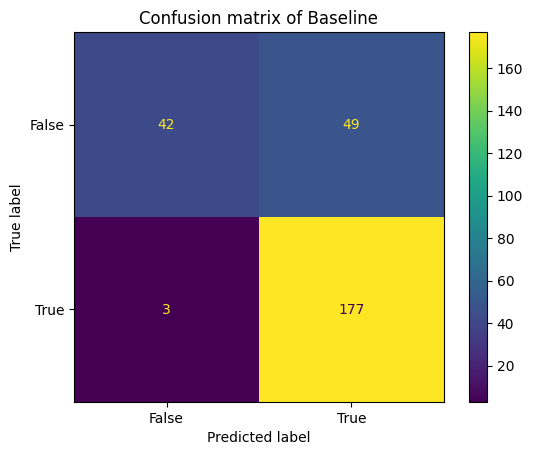

+-----------+---------+
|  Metrics  | Results |
+-----------+---------+
|  ACCURACY |   80.8  |
| PRECISION |   78.3  |
|   RECALL  |   98.3  |
|    F_1    |   87.2  |
|   F_beta  |   97.9  |
+-----------+---------+


In [110]:
ground_truth = junctionDataset.get_ground_truth_corrected()
drive_trough_and_tl_state_with_invalid = tl_lane_stats.rename(columns={"sequence_head_lane_id": "lane_id"})
groundtruth_vs_prediction = ground_truth.merge(drive_trough_and_tl_state_with_invalid, on=["tl_id", "lane_id"], how="left")


groundtruth_vs_prediction_notna = groundtruth_vs_prediction.dropna().copy()
visualize_confusion_matrix(groundtruth_vs_prediction_notna["relation"], groundtruth_vs_prediction_notna["predicted_relation"], "Confusion matrix of Baseline")
visualize_metrics(groundtruth_vs_prediction_notna["relation"], groundtruth_vs_prediction_notna["predicted_relation"], "Metrics of Baseline")


### Prior

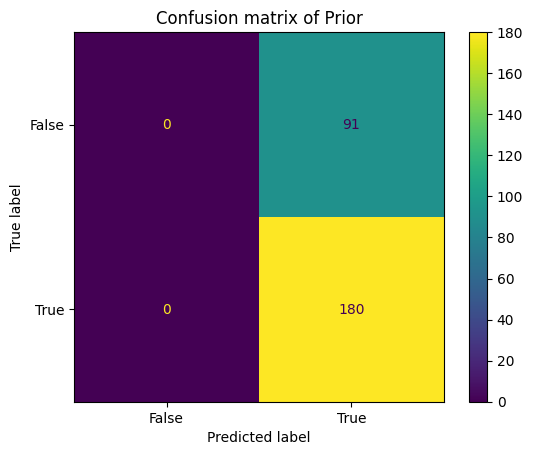

+-----------+---------+
|  Metrics  | Results |
+-----------+---------+
|  ACCURACY |   66.4  |
| PRECISION |   66.4  |
|   RECALL  |  100.0  |
|    F_1    |   79.8  |
|   F_beta  |   99.2  |
+-----------+---------+


In [111]:
groundtruth_vs_prediction_prior = groundtruth_vs_prediction_notna.copy()
groundtruth_vs_prediction_prior["predicted_relation"] = 1
visualize_confusion_matrix(groundtruth_vs_prediction_prior["relation"], groundtruth_vs_prediction_prior["predicted_relation"], "Confusion matrix of Prior")
visualize_metrics(groundtruth_vs_prediction_prior["relation"], groundtruth_vs_prediction_prior["predicted_relation"], "Metrics of Prior")


In [112]:
num_tl_lane_pairs = groundtruth_vs_prediction[groundtruth_vs_prediction.notna().all(axis=1)].shape[0]
num_not_classified = groundtruth_vs_prediction[groundtruth_vs_prediction.isna().any(axis=1)].shape[0]

### Summary

In [113]:
summary = f"Number of scenes: {num_scenes}\n" + \
          f"Number of agents: {num_agents}\n" + \
          f"Number of tl-lane pairs: {num_tl_lane_pairs} \n" + \
          f"Number of tl-lane pairs not classified: {num_not_classified}"

print(summary)

Number of scenes: 12925
Number of agents: 33747
Number of tl-lane pairs: 271 
Number of tl-lane pairs not classified: 8


### Save results

In [114]:
save_results = True
if save_results and ego_only:
    groundtruth_vs_prediction_notna.to_pickle("dataset/results/conservative/prediction_ego_only.pkl")
    print("Saved prediction results for ego only")
elif save_results and not ego_only :
    groundtruth_vs_prediction_notna.to_pickle("dataset/results/conservative/prediction_all_agents.pkl")
    print("Saved prediction results for all agents")

Saved prediction results for all agents


### Show Prediction Differences
To identify and imporve the classifier it can be helpful to analyze which labels have been predicted incorrectly.

In [453]:
diff = groundtruth_vs_prediction_notna.query("relation != predicted_relation").sort_values(by=["junction_id", "branch_id"])
diff

,tl_id,lane_id,relation,junction_id,branch_id,corrected,num_drives,num_unallowed_red_drive_throughts,num_red_drive_throughts_percentage,invalid_assoc,predicted_relation
17,3WL8,vLqW,0,3Ccg,S8XK4,0,3891.0,5.0,0.001285,False,1.0
20,FlE6,vLqW,0,3Ccg,S8XK4,0,1734.0,4.0,0.002307,False,1.0
26,umZo,vLqW,0,3Ccg,S8XK4,0,333.0,3.0,0.009009,False,1.0
30,RDa4,QLqW,0,3Ccg,S8XK4,0,351.0,15.0,0.042735,False,1.0
31,RDa4,vijX,0,3Ccg,S8XK4,0,113.0,7.0,0.061947,False,1.0
32,4Xis,iD65,0,3Ccg,WX0Uk,0,104.0,3.0,0.028846,False,1.0
36,CqSo,iD65,0,3Ccg,WX0Uk,0,242.0,7.0,0.028926,False,1.0
40,DDUl,iD65,0,3Ccg,WX0Uk,0,193.0,3.0,0.015544,False,1.0
48,nuVl,iD65,0,3Ccg,WX0Uk,0,227.0,5.0,0.022026,False,1.0
53,lO+m,BE65,0,3Ccg,WX0Uk,0,31.0,2.0,0.064516,False,1.0


In [509]:
pickle_df("dataset/results/conservative/groundtruth_vs_prediction_notna.pkl", groundtruth_vs_prediction_notna)